## Cat Dog Dataset

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

You can obtain the dataset from https://www.kaggle.com/c/dogs-vs-cats/data

This case study is adopted from https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

### 1. Import Library

In [16]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img, image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Model
from keras.layers import Dense
from keras import optimizers

mypath='/Users/gceran/Google Drive2/Courses/MagniMind/Mentorship Program/DL-MentorProgram/DL_Mentor_Week2/Class 2'
print(os.listdir(mypath))

['GenderIDTransfLearn.ipynb', '.DS_Store', 'cats_dogs_small', 'Icon\r', 'Keras CNN Dog or Cat Classifier-Vgg16-Transfer-Learning.ipynb', 'Week2-Class2-Inst', 'img', 'Week2-Class2-St.zip', '.ipynb_checkpoints', 'Week2-Class2-St']


### 2. Define Constants

In [45]:
FAST_RUN = True #False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### 3. Prepare Training Data

In [3]:
filenames = os.listdir(os.path.join(mypath, 'cats_dogs_small'))
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.shape

(2476, 2)

In [6]:
df.head()

,filename,category
0,dog.3144.jpg,1
1,dog.775.jpg,1
2,cat.12020.jpg,0
3,cat.8235.jpg,0
4,dog.7444.jpg,1


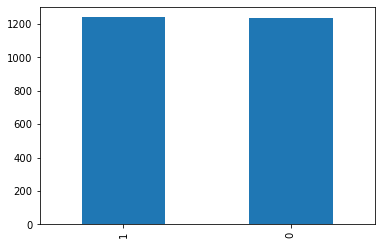

In [7]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

#### See sample image

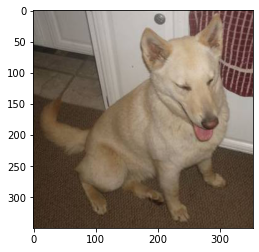

In [9]:
sample = random.choice(filenames)
pathimage=os.path.join(mypath, 'cats_dogs_small/')
image = load_img(pathimage+sample)
plt.imshow(image)

### 4. Build Model

In [10]:
from keras.applications.vgg16 import VGG16

***include_top:*** whether to include the 3 fully-connected layers at the top of the network.

In [11]:
vggmodel = VGG16(weights='imagenet', include_top=True)

In [12]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable = False

In [14]:
X= vggmodel.layers[-2].output # check whether -1 or -2

In [17]:
predictions = Dense(2, activation="softmax")(X)

In [18]:
model_final = Model(input = vggmodel.input, output = predictions)

/Users/gceran/opt/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [19]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [20]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### 5. Callbacks

In [40]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

Keras supports the early stopping of training via a callback called EarlyStopping.

This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.

The `EarlyStopping` callback is configured when instantiated via arguments.

The `monitor` allows you to specify the performance measure to monitor in order to end training.

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [41]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [43]:
callbacks = [earlystop, learning_rate_reduction]

### 6. Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [29]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [30]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

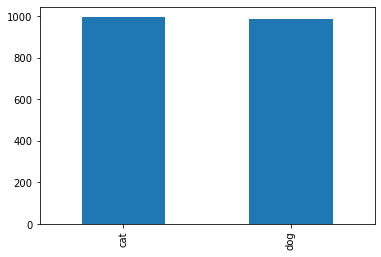

In [31]:
train_df['category'].value_counts().plot.bar()

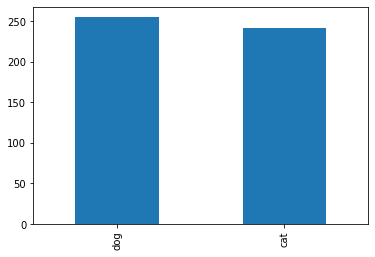

In [32]:
validate_df['category'].value_counts().plot.bar()

In [33]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=20


### 7. Traning Generator

In [47]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    pathimage, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1979 validated image filenames belonging to 2 classes.


/Users/gceran/opt/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


### Validation Generator

In [48]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    pathimage, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 496 validated image filenames belonging to 2 classes.


### 8. See how our generator work

In [49]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    pathimage, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


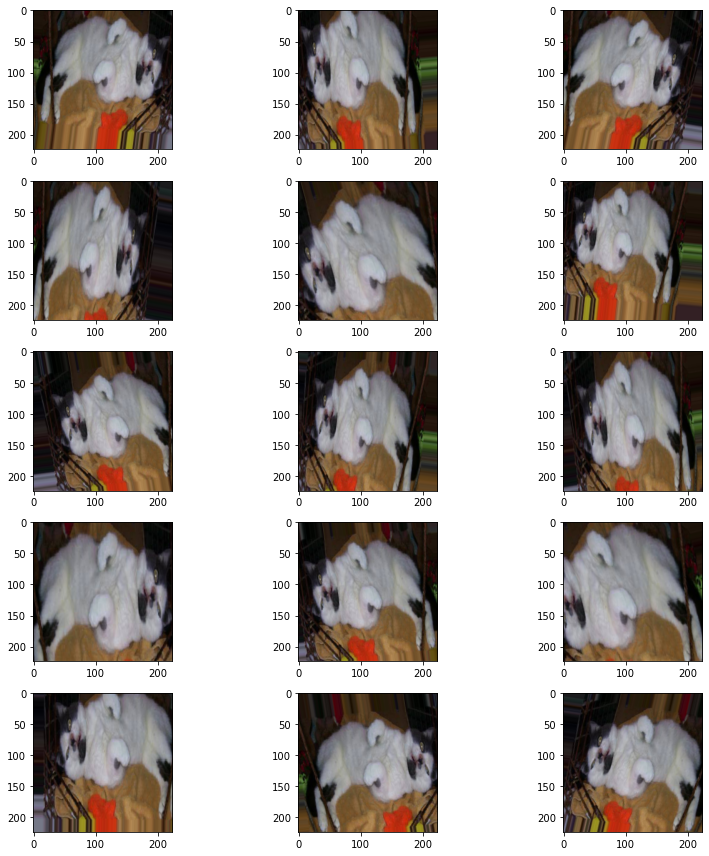

In [50]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

### 9. Fit Model

In [51]:
epochs=3 if FAST_RUN else 50
history = model_final.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
99/99 [==============================] - 4164s 42s/step - loss: 0.6006 - accuracy: 0.6599 - val_loss: 0.4818 - val_accuracy: 0.8062
Epoch 2/3
99/99 [==============================] - 1248s 13s/step - loss: 0.4573 - accuracy: 0.7878 - val_loss: 0.3520 - val_accuracy: 0.8340
Epoch 3/3
99/99 [==============================] - 4105s 41s/step - loss: 0.4249 - accuracy: 0.8009 - val_loss: 0.3719 - val_accuracy: 0.7227


### 10. Save Model

In [41]:
model_final.save_weights("vgg16_1https://github.com/ageron/handson-ml/issues/265.h5")